<a href="https://colab.research.google.com/github/matteraggi/maritimeAIS/blob/main/TrainingAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install + Import**

In [60]:
# === Installazioni necessarie su Colab ===
!pip install pandas numpy pyarrow torch matplotlib scikit-learn

import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, os
from pyproj import Transformer
from google.colab import drive
import math
import json

# **Mount Drive**

In [61]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **Parametri**

In [62]:
# --- CONFIG ---
DATA_FILE = "/content/drive/MyDrive/preprocessed/ais_final.parquet"
SEQUENCE_LEN = 60
DELTA_T = "1min"
FEATURES = [
    "X", "Y", "SOG", "COG", "Heading",
    "dX", "dY", "dSOG", "dCOG", "dHeading",
    "dist_step", "speed_xy", "accel_xy", "turn_rate", "dir_xy",
    "SOG_mean10", "SOG_std10",
    "COG_mean10", "COG_std10",
    "Heading_mean10", "Heading_std10",
    "speed_xy_mean10", "speed_xy_std10"
]
TARGET_IDX = [0, 1]   # prevedi solo X,Y
TEST_RATIO = 0.15
VAL_RATIO = 0.15
MMSI_SEED = 42
torch.manual_seed(MMSI_SEED)
np.random.seed(MMSI_SEED)
random.seed(MMSI_SEED)

# MODEL HP
INPUT_SIZE = len(FEATURES)   # ora più grande
HIDDEN_SIZE = 128            # aumenta leggermente la capacità
NUM_LAYERS = 2
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# ATTACK / EVAL
STD_X_M = None   # se calcoli fuori, assegna qui
STD_Y_M = None

# ANOMALIES
ATTACK_ENABLE = True
ATTACK_PROB   = 0.3 # percentuale (0-1) di elementi attaccati
DRIFT_METERS  = 500             # se sweep vuoto, usa questo
DRIFT_SWEEP_METERS = [2000, 5000, 10000, 20000]

# **Load Dataset e JSON**

In [65]:
# === PATH ===
BASE_PATH = "/content/drive/MyDrive/preprocessed"
DATA_FILE = f"{BASE_PATH}/ais_final.parquet"
MEAN_FILE = f"{BASE_PATH}/feature_means.json"
STD_FILE  = f"{BASE_PATH}/feature_stds.json"

# === CARICAMENTO DATASET ===
df = pd.read_parquet(DATA_FILE)
print("Righe totali:", len(df))

# === CARICAMENTO STATISTICHE ===
with open(MEAN_FILE, "r") as f:
    feature_means = json.load(f)
with open(STD_FILE, "r") as f:
    feature_stds = json.load(f)

print("Feature means:", feature_means)
print("Feature stds:", feature_stds)

# === CALCOLO SCALE METRICHE (X,Y reali) ===
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
STD_X_M = float(xs_m.std()) if STD_X_M is None else STD_X_M
STD_Y_M = float(ys_m.std()) if STD_Y_M is None else STD_Y_M
print(f"STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

# === SPLIT PER MMSI ===
mmsi_list = df["MMSI"].unique()
rng = np.random.RandomState(MMSI_SEED)
rng.shuffle(mmsi_list)

n = len(mmsi_list)
n_test = int(TEST_RATIO * n)
n_val  = int(VAL_RATIO * n)

test_mmsi = mmsi_list[:n_test]
val_mmsi  = mmsi_list[n_test:n_test+n_val]
train_mmsi = mmsi_list[n_test+n_val:]

df_train = df[df["MMSI"].isin(train_mmsi)]
df_val   = df[df["MMSI"].isin(val_mmsi)]
df_test  = df[df["MMSI"].isin(test_mmsi)]

print(f"Train navi: {len(train_mmsi)}, Val navi: {len(val_mmsi)}, Test navi: {len(test_mmsi)}")

available = [f for f in FEATURES if f in df.columns]
print(df[available].describe().T[["mean", "std", "min", "max"]])
print("Missing values:\n", df[available].isna().sum())

Righe totali: 185731
Feature means: {'X': 209699.3485615882, 'Y': 3296090.3875009352, 'SOG': 1.4261196561, 'COG': 209.004364761, 'Heading': 236.4842529435}
Feature stds: {'X': 33332.4555200091, 'Y': 33116.4317524409, 'SOG': 2.8284330102, 'COG': 107.2568647914, 'Heading': 121.3349535405}
STD_X_M=33329.30 m  STD_Y_M=33116.41 m
Train navi: 14, Val navi: 2, Test navi: 2
                         mean        std         min         max
X                4.124750e-05   0.999908   -5.343412    2.167709
Y               -5.142053e-06   1.000002   -2.824842    0.837053
SOG             -1.890219e-05   0.999979   -0.504208    5.011213
COG              9.009550e-06   1.000016   -1.948634    1.407795
Heading         -1.745160e-05   0.999996   -1.949020    2.262462
dX               1.549511e-05   0.002132   -0.036173    0.018574
dY              -1.901964e-05   0.001865   -0.018828    0.015385
dSOG             1.713216e-05   0.256430   -3.641592    3.889079
dCOG             3.407221e-05   0.554728   -3.

# **Creazione finestre temporali per train, val e test**

In [66]:
def create_sequences(df, seq_len=SEQUENCE_LEN, features=FEATURES):
    Xs, ys = [], []
    for mmsi, group in df.groupby("MMSI"):
        group = group.sort_values("BaseDateTime")
        data = group[features].values
        for i in range(len(data) - seq_len):
            Xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len, :2])  # prevedi solo X,Y
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(df_train)
X_val,   y_val   = create_sequences(df_val)
X_test,  y_test  = create_sequences(df_test)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

Train: 150335  Val: 12838  Test: 21478


# **LSTM model (Long Short Term Memory)**

In [7]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=NUM_LAYERS, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # ultima uscita
        return out

model_lstm = TrajectoryLSTM()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LR)

# **Training LSTM**

In [14]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lstm.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lstm(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # --- validazione ---
    model_lstm.eval()
    with torch.no_grad():
        val_pred = model_lstm(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model_lstm.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva anche su Google Drive ===
!cp best_model_lstm.pt "/content/drive/MyDrive/best_model_lstm.pt"
print("✅ Modello salvato su Drive come 'best_model_lstm.pt'")

Epoch 1/10 | Train loss: 0.000084 | Val loss: 0.001774
Epoch 2/10 | Train loss: 0.000434 | Val loss: 0.004327
Epoch 3/10 | Train loss: 0.000114 | Val loss: 0.002228
Epoch 4/10 | Train loss: 0.000155 | Val loss: 0.004231
Epoch 5/10 | Train loss: 0.000050 | Val loss: 0.002440
Epoch 6/10 | Train loss: 0.000031 | Val loss: 0.001592
Epoch 7/10 | Train loss: 0.000076 | Val loss: 0.006398
Epoch 8/10 | Train loss: 0.000028 | Val loss: 0.002334
Epoch 9/10 | Train loss: 0.000043 | Val loss: 0.002933
Epoch 10/10 | Train loss: 0.000036 | Val loss: 0.001547
✅ Modello salvato su Drive come 'best_model_lstm.pt'


# **Carica LSTM**

In [9]:
!cp "/content/drive/MyDrive/best_model_lstm.pt" .

model_lstm = TrajectoryLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2)
model_lstm.load_state_dict(torch.load("best_model_lstm.pt", map_location="cpu"))
model_lstm.eval()

print("✅ Modello caricato da Drive e pronto per inferenza/anomaly detection")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Modello caricato da Drive e pronto per inferenza/anomaly detection


# **LNN Model**

In [67]:
class TrajectoryLNN(nn.Module):
    def __init__(self, input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # appiattisci la sequenza (batch, seq_len, feat) → (batch, seq_len * feat)
        x = x.view(x.size(0), -1)
        return self.net(x)

model_lnn = TrajectoryLNN()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model_lnn.parameters(), lr=LR)

# **Training LNN**

In [17]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model_lnn.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model_lnn(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # validazione
    model_lnn.eval()
    with torch.no_grad():
        val_pred = model_lnn(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"[LNN] Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model_lnn.state_dict(), "best_model_lnn.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva su Drive ===
!cp best_model_lnn.pt "/content/drive/MyDrive/best_model_lnn.pt"
print("✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'")

[LNN] Epoch 1/10 | Train loss: 0.001063 | Val loss: 0.001633
[LNN] Epoch 2/10 | Train loss: 0.000327 | Val loss: 0.000813
[LNN] Epoch 3/10 | Train loss: 0.000309 | Val loss: 0.000673
[LNN] Epoch 4/10 | Train loss: 0.000575 | Val loss: 0.000851
[LNN] Epoch 5/10 | Train loss: 0.000397 | Val loss: 0.000742
[LNN] Epoch 6/10 | Train loss: 0.000258 | Val loss: 0.000456
[LNN] Epoch 7/10 | Train loss: 0.000644 | Val loss: 0.000615
[LNN] Epoch 8/10 | Train loss: 0.000203 | Val loss: 0.000686
[LNN] Epoch 9/10 | Train loss: 0.000181 | Val loss: 0.000415
[LNN] Epoch 10/10 | Train loss: 0.000138 | Val loss: 0.000419
✅ Modello LNN salvato su Drive come 'best_model_lnn.pt'


# **Carica LNN**

In [68]:
!cp "/content/drive/MyDrive/best_model_lnn.pt" .

model_lnn = TrajectoryLNN(input_size=SEQUENCE_LEN * INPUT_SIZE, hidden_size=128, output_size=2)
model_lnn.load_state_dict(torch.load("best_model_lnn.pt", map_location="cpu"))
model_lnn.eval()

print("✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection")

✅ Modello LNN caricato da Drive e pronto per inferenza/anomaly detection


# **Creazione anomalie (spoofing simulato)**

In [69]:
def simulate_silent_drift(X, std_x_m, meters, prob=0.3, rng=None):
    """
    Applica uno spoofing silenzioso continuo e realistico.
    Ogni sequenza subisce un drift progressivo coerente nel tempo.
    """
    rng = rng or np.random.RandomState(42)
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    drift_z = meters / std_x_m
    cumulative_drift_x, cumulative_drift_y = 0, 0

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i].copy()
            dx = np.linspace(cumulative_drift_x, cumulative_drift_x + drift_z, seq.shape[0])
            dy = np.linspace(cumulative_drift_y, cumulative_drift_y + drift_z, seq.shape[0]) * rng.choice([-1, 1])
            seq[:, 0] += dx - dx[0]
            seq[:, 1] += dy - dy[0]
            X_att[i] = seq
            labels[i] = 1
            cumulative_drift_x += drift_z
            cumulative_drift_y += drift_z * rng.choice([-1, 1])
    return X_att, labels


def simulate_kinematic_attack(X, std_x_m, meters, prob=0.3, rng=None):
    rng = rng or np.random.RandomState(42)
    drift_z = meters / std_x_m
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)
    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i]
            seq[:,0] += drift_z  # cambia X
            # NON cambia COG o SOG -> incoerenza fisica
            X_att[i] = seq
            labels[i] = 1
    return X_att, labels

# **Modello da valutare**

In [70]:
model = model_lnn



# **Valutazione e visualizzazione**

DEBUG STD: 33329.295523984714 33116.41141777599

=== Drift 2000 m ===
Errore medio in metri: clean=1153.07 m, attack=1360.81 m


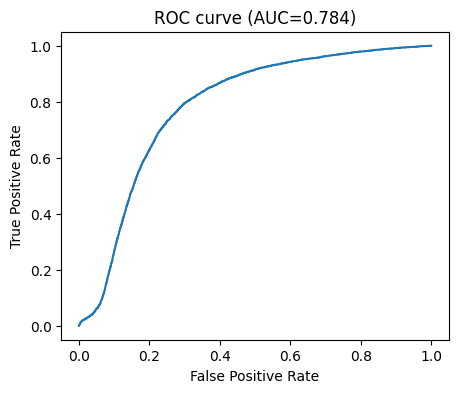

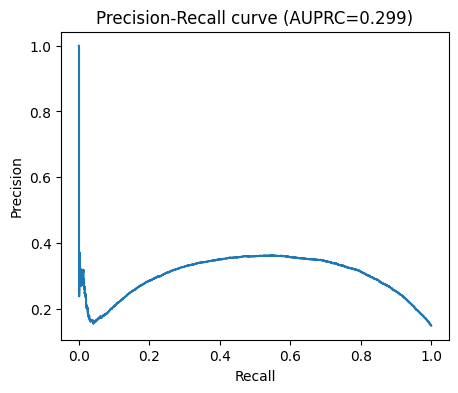

Errore medio (clean=0.00145, attack=0.00173) σ_clean=0.00461 σ_attack=0.00486
Drift 2000 m →  TPR@99p=1.3%

=== Drift 5000 m ===
Errore medio in metri: clean=1153.07 m, attack=1976.25 m


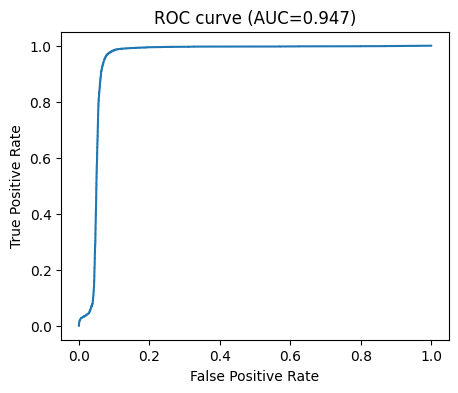

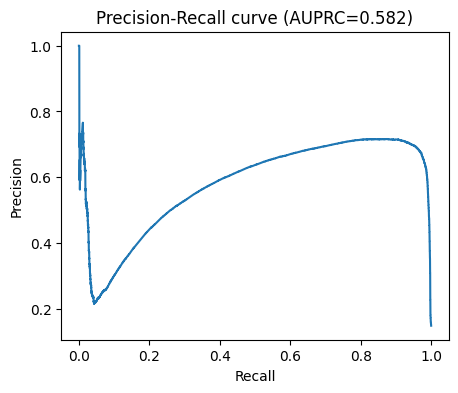

Errore medio (clean=0.00145, attack=0.00331) σ_clean=0.00461 σ_attack=0.00604
Drift 5000 m →  TPR@99p=1.6%

=== Drift 10000 m ===
Errore medio in metri: clean=1153.07 m, attack=3022.06 m


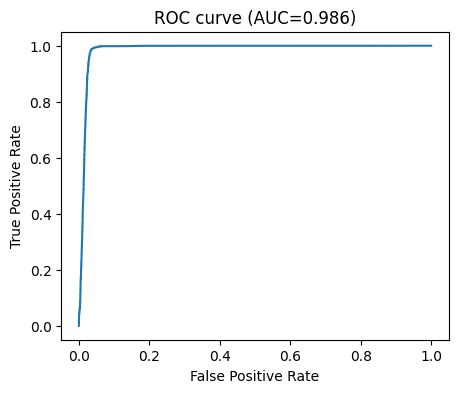

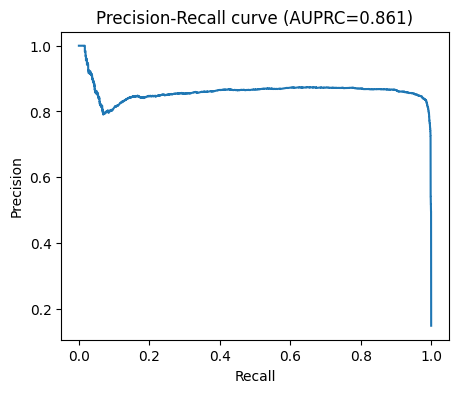

Errore medio (clean=0.00145, attack=0.00867) σ_clean=0.00461 σ_attack=0.01282
Drift 10000 m →  TPR@99p=11.3%

=== Drift 20000 m ===
Errore medio in metri: clean=1153.07 m, attack=5212.47 m


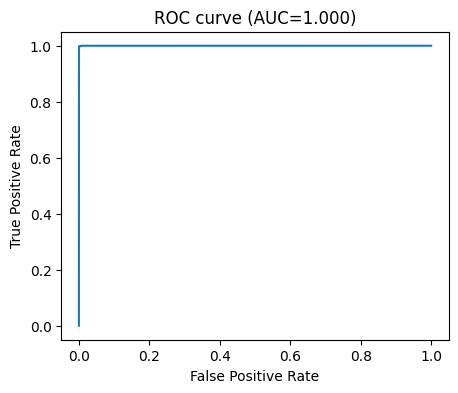

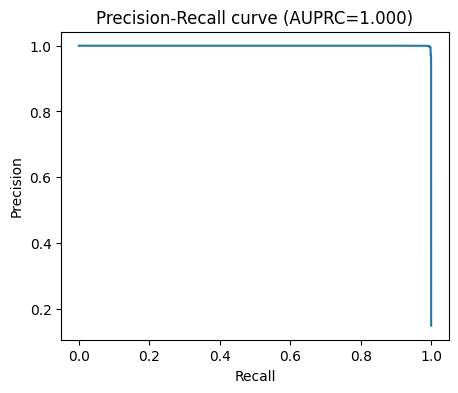

Errore medio (clean=0.00145, attack=0.03073) σ_clean=0.00461 σ_attack=0.04605
Drift 20000 m →  TPR@99p=30.4%

[Risultati sweep]
 2000 m  TPR@99p=1.3%
 5000 m  TPR@99p=1.6%
10000 m  TPR@99p=11.3%
20000 m  TPR@99p=30.4%


In [81]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# === Predizioni su test pulito ===
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_test_t = to_tensor(X_test)
model.eval()
with torch.no_grad():
    pred_clean = model(X_test_t).numpy()

err_clean = np.mean((pred_clean - y_test)**2, axis=1)

# === Denormalizzazione (usa i JSON) ===
def denorm_xy(array):
    arr = array.copy()
    arr[:, 0] = arr[:, 0] * feature_stds["X"] + feature_means["X"]
    arr[:, 1] = arr[:, 1] * feature_stds["Y"] + feature_means["Y"]
    return arr

y_test_denorm = denorm_xy(y_test)
pred_clean_denorm = denorm_xy(pred_clean)


# === Funzione di valutazione attacco ===
def eval_attack(drift_m):
    # --- genera dati attaccati ---
    X_attack, labels = simulate_silent_drift(
        X_test, std_x_m=STD_X_M, meters=drift_m, prob=ATTACK_PROB
    )

    # --- predizione ---
    with torch.no_grad():
        pred_att = model(to_tensor(X_attack)).numpy()

    # --- denormalizza predizioni ---
    pred_att_denorm = denorm_xy(pred_att)

    # --- errori normalizzati e in metri ---
    err_att = np.mean((pred_att - y_test)**2, axis=1)
    err_clean_m = np.sqrt(((pred_clean_denorm - y_test_denorm)**2).sum(axis=1))
    err_att_m   = np.sqrt(((pred_att_denorm   - y_test_denorm)**2).sum(axis=1))

    print(f"\n=== Drift {drift_m} m ===")
    print(f"Errore medio in metri: clean={err_clean_m.mean():.2f} m, attack={err_att_m.mean():.2f} m")

    # --- metriche di detection ---
    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])

    fpr, tpr, _ = roc_curve(labels_all, scores_all)
    prec, rec, _ = precision_recall_curve(labels_all, scores_all)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(rec, prec)

    # --- grafici ROC e PR ---
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr)
    plt.title(f"ROC curve (AUC={roc_auc:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    # --- soglia e detection rate ---
    thr = np.percentile(err_clean, 99)
    tpr_99 = float(np.mean(err_att > thr))

    print(f"Errore medio (clean={err_clean.mean():.5f}, attack={err_att.mean():.5f}) "
          f"σ_clean={err_clean.std():.5f} σ_attack={err_att.std():.5f}")
    print(f"Drift {drift_m} m →  TPR@99p={tpr_99*100:.1f}%")

    # ritorna anche le predizioni denormalizzate per i plot successivi
    return drift_m, tpr_99, roc_auc, pr_auc, err_att, labels_all, scores_all, pred_att_denorm


# === Controllo STD ===
if STD_X_M is None:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
    STD_X_M = float(xs_m.std())
    STD_Y_M = float(ys_m.std())
    print(f"[Auto-calibrato] STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

print("DEBUG STD:", STD_X_M, STD_Y_M)

# === Sweep attacchi ===
if ATTACK_ENABLE:
    results = []
    last_err_att = None
    labels_all, scores_all, pred_attack_denorm = None, None, None

    if DRIFT_SWEEP_METERS:
        for d in DRIFT_SWEEP_METERS:
            drift_m, tpr, roc_auc, pr_auc, err_att, labels_all, scores_all, pred_attack = eval_attack(d)
            results.append((drift_m, tpr))
            last_err_att = err_att

        print("\n[Risultati sweep]")
        for d, tpr in results:
            print(f"{d:>5} m  TPR@99p={tpr*100:.1f}%")
    else:
        _, tpr, roc_auc, pr_auc, last_err_att, labels_all, scores_all, pred_attack = eval_attack(DRIFT_METERS)

# **Genera traiettoria completa**

In [74]:
def _xy_to_sog_cog(prev_xy, next_xy, dt_min=1.0):
    dx_m = (next_xy[0] - prev_xy[0]) * STD_X_M
    dy_m = (next_xy[1] - prev_xy[1]) * STD_Y_M
    dist_m = math.hypot(dx_m, dy_m)
    sog_kn = (dist_m / (dt_min*60.0)) * 1.94384
    cog_deg = (math.degrees(math.atan2(dy_m, dx_m)) + 360) % 360
    return sog_kn, cog_deg

def generate_full_trajectory(model, X_start, steps):
    model.eval()
    preds = []
    x_curr = X_start.clone()

    for _ in range(steps):
        with torch.no_grad():
            y_pred = model(x_curr)
        preds.append(y_pred.cpu().numpy().flatten())

        new_step = x_curr[:, -1, :].clone()
        new_step[0, 0:2] = y_pred  # aggiorna solo X,Y
        x_curr = torch.cat([x_curr[:, 1:, :], new_step.unsqueeze(1)], dim=1)

    return np.array(preds)

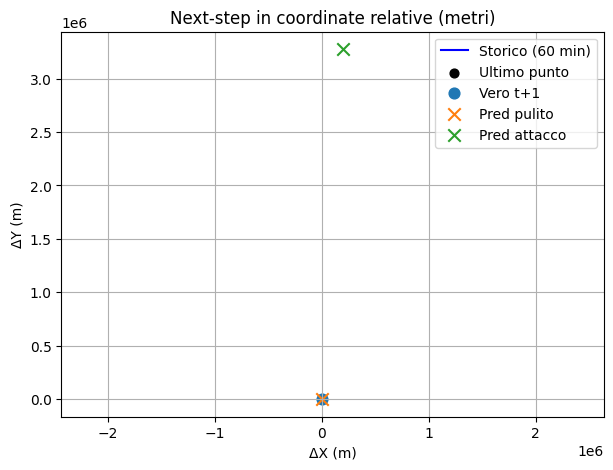

In [82]:
# === CASE STUDY: next-step relativo ===
N = len(y_test)
idx_att = np.where(labels_all[N:] == 1)[0]
i = int(idx_att[np.argmax(last_err_att[idx_att])])

hist_xy   = X_test[i][:, :2]
true_xy   = y_test[i]
pred_xy   = pred_clean[i]
att_xy    = pred_attack[i]

# centra sull'ultimo punto
x0, y0 = hist_xy[-1]
hist_rel = hist_xy - np.array([x0, y0])
true_rel = true_xy - np.array([x0, y0])
pred_rel = pred_xy - np.array([x0, y0])
att_rel  = att_xy  - np.array([x0, y0])

# converti in metri (solo differenze)
# se i dati sono già denormalizzati, basta la differenza in metri reali
hist_m = hist_rel
true_m = true_rel
pred_m = pred_rel
att_m  = att_rel

plt.figure(figsize=(7,5))
plt.plot(hist_m[:,0], hist_m[:,1], 'b-', label="Storico (60 min)")
plt.scatter(0, 0, c='k', s=40, label="Ultimo punto")
plt.scatter(true_m[0], true_m[1], s=60, label="Vero t+1")
plt.scatter(pred_m[0], pred_m[1], marker='x', s=80, label="Pred pulito")
plt.scatter(att_m[0],  att_m[1],  marker='x', s=80, label="Pred attacco")
plt.axis('equal'); plt.grid(True)
plt.xlabel("ΔX (m)"); plt.ylabel("ΔY (m)")
plt.title("Next-step in coordinate relative (metri)")
plt.legend(); plt.show()

# **Plot errori temporali**

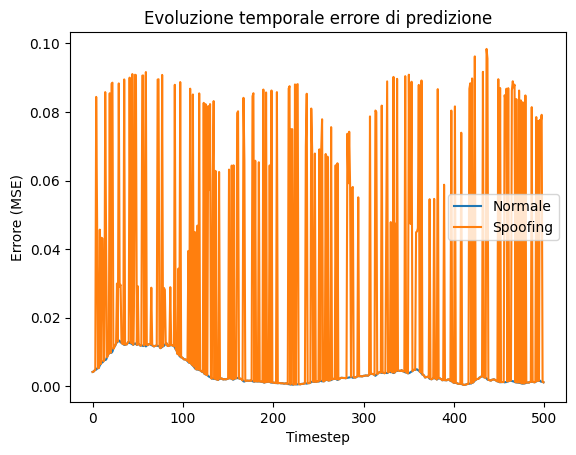

In [83]:
plt.plot(err_clean[:500], label='Normale')
plt.plot(err_att[:500], label='Spoofing')
plt.xlabel("Timestep"); plt.ylabel("Errore (MSE)")
plt.title("Evoluzione temporale errore di predizione")
plt.legend(); plt.show()

# **ROC / PR curve**

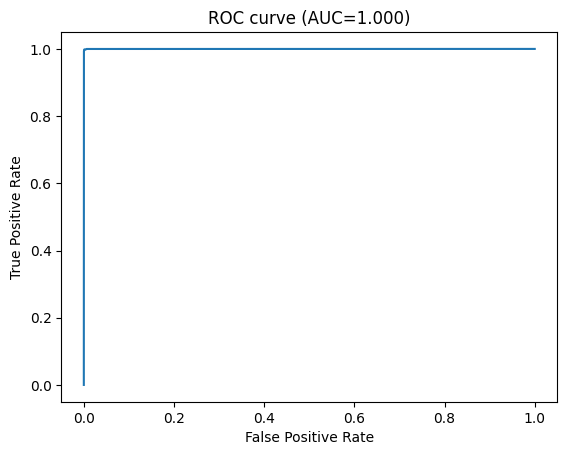

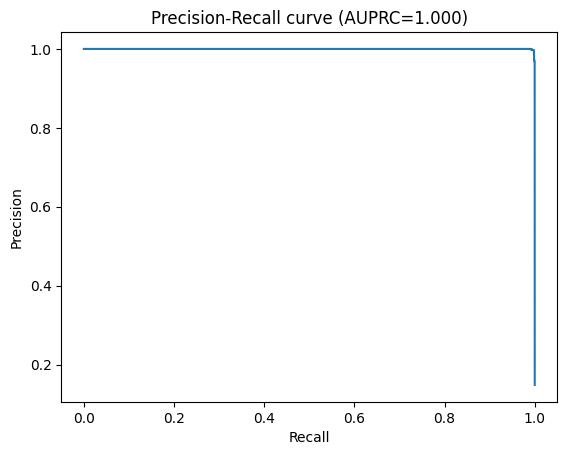

In [84]:
# --- importa la funzione originale ---
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# --- ricalcola ---
fpr, tpr, _ = roc_curve(labels_all, scores_all)
prec, rec, _ = precision_recall_curve(labels_all, scores_all)

roc_auc = auc(fpr, tpr)
pr_auc  = auc(rec, prec)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curve (AUC={roc_auc:.3f})")
plt.show()

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall curve (AUPRC={pr_auc:.3f})")
plt.show()


# **Heatmap “offset vs TPR”**

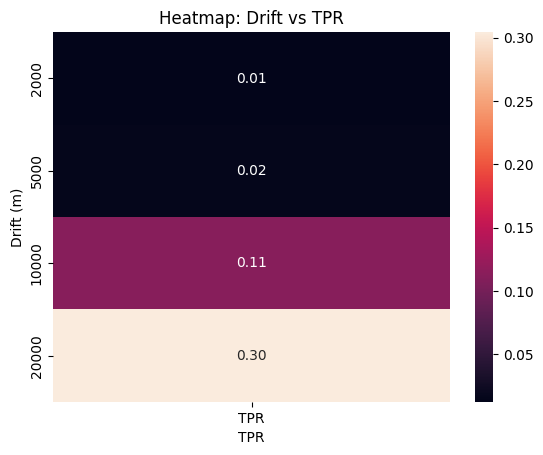

In [85]:
data = pd.DataFrame(results, columns=["drift_m", "TPR"])
sns.heatmap(data.pivot_table(index="drift_m", values="TPR"), annot=True, fmt=".2f")
plt.title("Heatmap: Drift vs TPR"); plt.xlabel("TPR"); plt.ylabel("Drift (m)")
plt.show()

# **Case study: traiettoria su piano cartesiano**

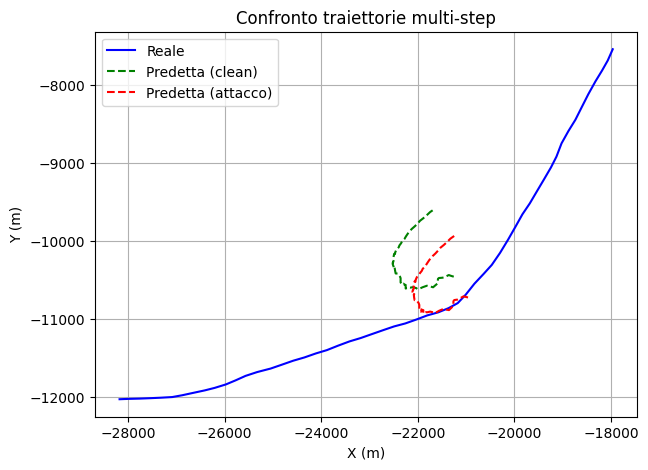

In [86]:
# === CASE STUDY: multi-step ===
seq_init = torch.tensor(X_test[i:i+1], dtype=torch.float32)

traj_clean  = generate_full_trajectory(model, seq_init, steps=60)
X_attack, _ = simulate_silent_drift(X_test[i:i+1], std_x_m=STD_X_M, meters=DRIFT_METERS, prob=1.0)
traj_attack = generate_full_trajectory(model, torch.tensor(X_attack, dtype=torch.float32), steps=60)

true_traj = np.vstack([X_test[i, :, :2], y_test[i]])

plt.figure(figsize=(7,5))
plt.plot(true_traj[:,0]*STD_X_M, true_traj[:,1]*STD_Y_M, 'b-', label="Reale")
plt.plot(traj_clean[:,0]*STD_X_M, traj_clean[:,1]*STD_Y_M, 'g--', label="Predetta (clean)")
plt.plot(traj_attack[:,0]*STD_X_M, traj_attack[:,1]*STD_Y_M, 'r--', label="Predetta (attacco)")
plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.legend(); plt.title("Confronto traiettorie multi-step")
plt.grid(True); plt.show()